# SETUP

### IMPORTS


In [22]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

### DISPLAY SETUP

In [343]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images.resize(images.shape[0], 3, 28, 28)
    images = torch.from_numpy(images)
    images = images.permute(0, 2, 3, 1) # becomes N x H x W x C
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.2, hspace=0.2)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([28, 28, 3]), vmin=0,vmax=255)
    return 

### DATA

In [348]:
X_train = None
X_display = None

def load_data():
    global X_train
    global X_display
    
    X_train = np.loadtxt("new-data.txt")
    # each element is 3 x width x height for new, height x width x channels for old
    X_display = X_train.copy()
        
    X_train_temp = X_train.reshape(-1, 3)
    X_train_mean = np.mean(X_train_temp, axis=0)
    X_train_std = np.std(X_train_temp, axis=0)
    X_train = X_train / 255
#     X_train = (X_train_temp - X_train_mean) / X_train_std
    #X_train.resize(711, 100, 100, 3)
    X_train.resize(711, 28, 28, 3)
    
    X_train = torch.from_numpy(X_train)

    X_train = X_train.permute(0, 3, 1, 2) # becomes N x C x H x W
#     print(X_train)
    print(X_train.shape)
    
load_data()

torch.Size([711, 3, 28, 28])


### HELPER FUNCTIONS

In [24]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    rand = torch.rand([batch_size, dim]) * 2 - 1
    return rand

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

### MISC SETUP

In [145]:
batch_size = 711
NOISE_DIM = 96

### CPU OR GPU

In [26]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# GAN

### SETUP FUNCTIONS

In [260]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    
    sq_real_loss = (scores_real - 1) ** 2
    sq_fake_loss = (scores_fake ** 2)
    
    
    loss = sq_real_loss.mean() / 2 + sq_fake_loss.mean() / 2
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Variable containing the loss.
    """
    sq_loss = (scores_fake - 1) ** 2
    loss = sq_loss.mean() / 2
    return loss

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    fake = logits_fake.type(dtype)
    real = logits_real.type(dtype)
    true_fake_labels = Variable(torch.zeros_like(logits_fake)).type(dtype)
    true_real_labels = Variable(torch.ones_like(logits_fake)).type(dtype)
    loss_fake = bce_loss(fake, true_fake_labels)
    loss_real = bce_loss(real, true_real_labels)
    loss = loss_fake + loss_real
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    true_labels = Variable(torch.ones_like(logits_fake)).type(dtype)
    fake = logits_fake.type(dtype)

    loss = bce_loss(fake, true_labels)
    
    return loss

In [28]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

In [345]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=50, 
              batch_size=711, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    
    X_train_batches = []
    batch_count = 0
#     while True:
#         if (batch_count + 1) * batch_size > X_train.shape[0]: 
#             break
#         else: 
#             X_train_batches.append(X_train[batch_count*batch_size:(batch_count+1)*batch_size])
#         batch_count += 1
    X_train_batches.append(X_train)

    
    
    for epoch in range(num_epochs):
#         for x in X_train_batches:
        x = X_train
#         if len(x) != batch_size:
#             continue
#         if iter_count % 2 == 0:
        D_solver.zero_grad()
        real_data = Variable(x).type(dtype)
        logits_real = D(real_data).type(dtype)

        g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
        fake_images = G(g_fake_seed).detach() / 2 + 0.5
        logits_fake = D(fake_images.view(batch_size, 3, 28, 28))

        d_total_error = discriminator_loss(logits_real, logits_fake)
        d_total_error.backward()        
        D_solver.step()

        
        
        G_solver.zero_grad()
        g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
        fake_images = G(g_fake_seed) / 2 + 0.5

        gen_logits_fake = D(fake_images.view(batch_size, 3, 28, 28))
        g_error = generator_loss(gen_logits_fake)
        g_error.backward()
        G_solver.step()

        if (iter_count % show_every == 0):
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
            imgs_numpy = fake_images.data.cpu().numpy()
            show_images(imgs_numpy[0:16])
            plt.show()
            print()
            print()
            print()
        iter_count += 1
    return G

### DISCRIMINATOR AND GENERATOR

In [64]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 3, 28, 28),
#        Unflatten(batch_size, 3, 100, 100),
        nn.Conv2d(3, 32, 5),
        nn.LeakyReLU(0.01, inplace=True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, 5),
        nn.LeakyReLU(0.01, inplace=True),
        nn.MaxPool2d(2, stride=2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.Linear(4*4*64, 1)
#         nn.Linear(22*22*64, 22*22*64),
#         nn.Linear(22*22*64, 1)
    )

data = Variable(X_train[:batch_size]).type(dtype)
print(data.size())
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([713, 3, 28, 28])
torch.Size([713, 1])


In [229]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        #Flatten(),
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(7*7*128),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = Variable(torch.randn(batch_size, NOISE_DIM)).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

C:\Users\ngs\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


torch.Size([711, 2352])

C:\Users\ngs\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\ngs\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter: 0, D: 1.388, G:0.06526


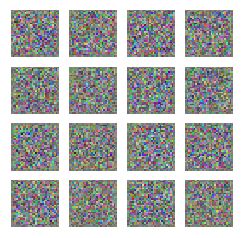




Iter: 50, D: 1.389, G:0.6536


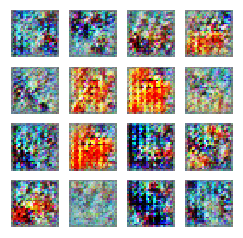




Iter: 100, D: 1.381, G:0.6902


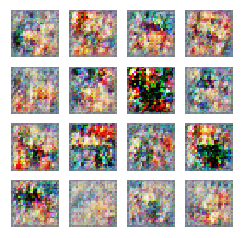




Iter: 150, D: 1.387, G:0.6968


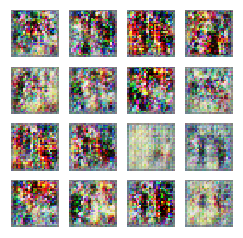

In [349]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

G_ac = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=200)

# noise_size = 96

# g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
# fake_images = G_ac(g_fake_seed).detach()

# imgs_numpy = fake_images.data.cpu().numpy()

# show_images(imgs_numpy[0:4])
# plt.show()



C:\Users\ngs\Anaconda3\lib\site-packages\torch\tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


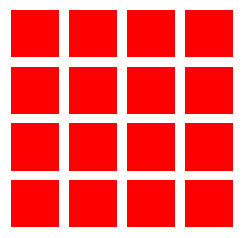

In [331]:
X_display.resize(711, 28, 28, 3)

# X_display = torch.from_numpy(X_display)
# X_display = X_display.permute(0, 3, 1, 2)
X_display = X_display.permute(0, 3, 1, 2) # becomes N x C x H x W
X_display = X_display.permute(0, 2, 3, 1) # becomes N x H x W x C


images = X_display[0:16]
images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)

sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

fig = plt.figure(figsize=(sqrtn, sqrtn))
gs = gridspec.GridSpec(sqrtn, sqrtn)
gs.update(wspace=0.2, hspace=0.2)

for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([28, 28, 3]) / 255, vmin=0,vmax=255)

# img = torch.transpose(X_display[0], 0, 2)/255 # rn is 3 x 28 x 28
# #print(img)

# plt.axis('off')

# plt.imshow(img, vmin=0,vmax=255)

plt.show()

In [295]:
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

G_DC_solver = get_optimizer(G_DC)


C:\Users\ngs\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


C:\Users\ngs\Anaconda3\lib\site-packages\torch\tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


0: 2606.669189453125


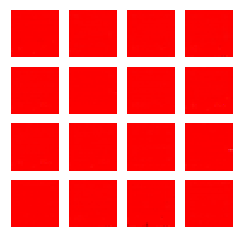

In [337]:
for i in range(200):
    G_DC_solver.zero_grad()
    g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
    fake_images = G_DC(g_fake_seed)
    fake_images = fake_images.resize(711, 3, 28, 28).type(dtype) / 2 + 0.5

    loss = torch.sum((X_train.type(dtype) - fake_images) ** 2)
    
    g_error = loss
    g_error.backward()
    G_DC_solver.step()
    if i % 200 == 0: print("{}: {}".format(i, loss))
    
imgs_numpy = fake_images.data.cpu().numpy()
show_images(imgs_numpy[0:16])
plt.show()


C:\Users\ngs\Anaconda3\lib\site-packages\torch\tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


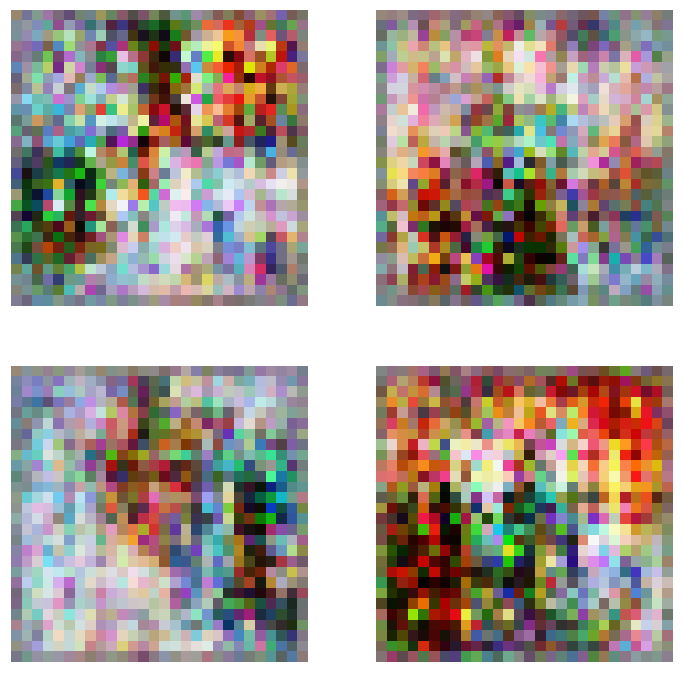

In [375]:
g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
fake_images = G_ac(g_fake_seed)
fake_images = fake_images.resize(711, 3, 28, 28).type(dtype) / 2 + 0.5
    
imgs_numpy = fake_images.data.cpu().numpy()
images = imgs_numpy[0:4] #shape is 1 x 3*28*28


images.resize(images.shape[0], 3, 28, 28)
images = torch.from_numpy(images)
images = images.permute(0, 2, 3, 1) # becomes N x H x W x C
images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

fig = plt.figure(figsize=(6 * sqrtn, 6 * sqrtn))
gs = gridspec.GridSpec(sqrtn, sqrtn)
gs.update(wspace=0.2, hspace=0.2)

for i, img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([28, 28, 3]), vmin=0,vmax=255)


plt.show()